# Detecting Malaria Cell using Convolutional Neural Network

kaggle: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria

The dataset contains 2 folders

- Infected
- Uninfected
- total of 27,558 images
 
This Dataset is taken from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/

Let's develop a CNN to classify cells as infected or uninfected.  

In [91]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [92]:
# Define the training and validation base directories

dir = 'cell_images/'

train_parasitized_dir = os.path.join(dir, 'Parasitized')
train_uninfected_dir = os.path.join(dir, 'Uninfected')


# Check the number of images for each class and set

print(f"There are {len(os.listdir(train_parasitized_dir))} images of parasitized cell for training.\n")

print(f"There are {len(os.listdir(train_uninfected_dir ))} images of uninfected cell for training.\n")


There are 13736 images of parasitized cell for training.

There are 13736 images of uninfected cell for training.



Sample parasitized image:


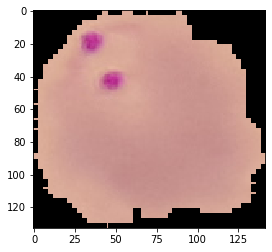


Sample uninfected image:


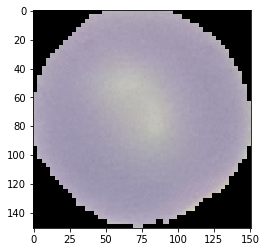

In [93]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print("Sample parasitized image:")
plt.imshow(load_img(f"{os.path.join(train_parasitized_dir, os.listdir(train_parasitized_dir)[0])}"))
plt.show()

print("\nSample uninfected image:")
plt.imshow(load_img(f"{os.path.join(train_uninfected_dir, os.listdir(train_uninfected_dir)[0])}"))
plt.show()

In [94]:
# Load the first example of parasitized
sample_image  = load_img(f"{os.path.join(train_parasitized_dir, os.listdir(train_parasitized_dir)[1])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Image 1 shape: {sample_array.shape}")

Image 1 shape: (130, 136, 3)


In [95]:
print(sample_array.max())
print(sample_array.min())

229.0
0.0


Let's create train, validation and test generators:

In [221]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from utils import train_val_generators

train_generator, validation_generator, test_generator = train_val_generators(dir)

Found 21976 images belonging to 2 classes.
Found 5494 images belonging to 2 classes.
Found 88 images belonging to 2 classes.


## Model 1:

Now, I will develop a simple baseline model only with feedforward layers.

In [98]:
model_1 = tf.keras.Sequential([

        tf.keras.layers.Flatten(input_shape=(120,120,3)),

        tf.keras.layers.Dense(units=64, activation = 'relu'),

        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(units=1, activation = 'sigmoid')
        
])


model_1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_13 (Flatten)        (None, 43200)             0         
                                                                 
 dense_26 (Dense)            (None, 64)                2764864   
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,764,929
Trainable params: 2,764,929
Non-trainable params: 0
_________________________________________________________________


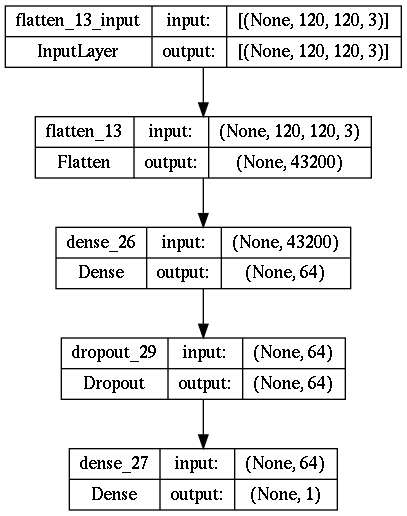

In [99]:
plot_model(model_1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [100]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history_m1 = model_1.fit_generator(
                                    generator = train_generator,
                                    steps_per_epoch = len(train_generator),
                                    epochs =20,
                                    validation_data = validation_generator,
                                    validation_steps=len(validation_generator),
                                    callbacks=[early_stop]
                                )

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/20
344/344 [==============================] - 575s 2s/step - loss: 0.9638 - accuracy: 0.5418 - val_loss: 0.6814 - val_accuracy: 0.5564
Epoch 2/20
344/344 [==============================] - 505s 1s/step - loss: 0.6676 - accuracy: 0.5848 - val_loss: 0.6740 - val_accuracy: 0.5890
Epoch 3/20
344/344 [==============================] - 383s 1s/step - loss: 0.6587 - accuracy: 0.5942 - val_loss: 0.6740 - val_accuracy: 0.5845
Epoch 4/20
344/344 [==============================] - 207s 589ms/step - loss: 0.6526 - accuracy: 0.6068 - val_loss: 0.6496 - val_accuracy: 0.6358
Epoch 5/20
344/344 [==============================] - 333s 971ms/step - loss: 0.6507 - accuracy: 0.6092 - val_loss: 0.6838 - val_accuracy: 0.5579
Epoch 6/20
344/344 [==============================] - 381s 1s/step - loss: 0.6468 - accuracy: 0.6161 - val_loss: 0.6406 - val_accuracy: 0.6536
Epoch 7/20
344/344 [==============================] - 294s 858ms/step - loss: 0.6503 - accuracy: 0.6117 - val_loss: 0.6511 - val_accurac

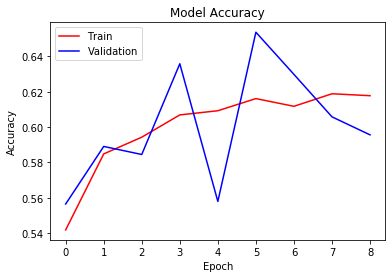

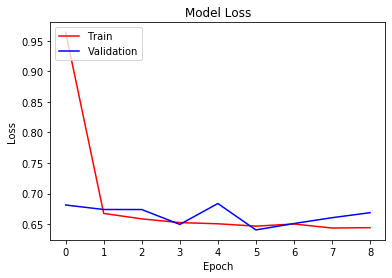

In [101]:
from utils import plotLearningCurve

plotLearningCurve(history_m1)

## Model 2:

As we can see, model 1 wasn't good enough to understand data. To improve it's performance, let's add convolutional layers:

In [102]:
model_2 = tf.keras.Sequential([

        tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(120,120,3)),

        tf.keras.layers.MaxPool2D(2,2),

        tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
        
        tf.keras.layers.MaxPool2D(2,2),
        
        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        
        tf.keras.layers.MaxPool2D(2,2),
        
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(units=64, activation = 'relu'),

        tf.keras.layers.Dense(units=1, activation = 'sigmoid')
        
])


model_2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [103]:
model_2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_494 (Conv2D)         (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 59, 59, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_495 (Conv2D)         (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_496 (Conv2D)         (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 13, 13, 64)     

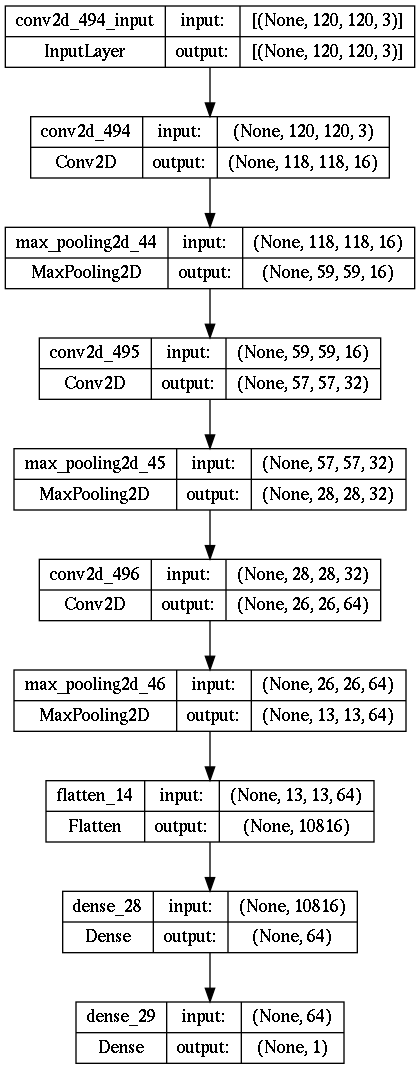

In [104]:
plot_model(model_2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [105]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history_m2 = model_2.fit_generator(
                                    generator = train_generator,
                                    steps_per_epoch = len(train_generator),
                                    epochs =20,
                                    validation_data = validation_generator,
                                    validation_steps=len(validation_generator),
                                    callbacks=[early_stop]
                                )

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/20
344/344 [==============================] - 724s 2s/step - loss: 0.4252 - accuracy: 0.7882 - val_loss: 0.2358 - val_accuracy: 0.9296
Epoch 2/20
344/344 [==============================] - 544s 2s/step - loss: 0.1537 - accuracy: 0.9507 - val_loss: 0.1883 - val_accuracy: 0.9412
Epoch 3/20
344/344 [==============================] - 221s 642ms/step - loss: 0.1329 - accuracy: 0.9571 - val_loss: 0.1796 - val_accuracy: 0.9383
Epoch 4/20
344/344 [==============================] - 192s 559ms/step - loss: 0.1227 - accuracy: 0.9597 - val_loss: 0.1773 - val_accuracy: 0.9408
Epoch 5/20
344/344 [==============================] - 144s 418ms/step - loss: 0.1136 - accuracy: 0.9613 - val_loss: 0.1768 - val_accuracy: 0.9410
Epoch 6/20
344/344 [==============================] - 132s 385ms/step - loss: 0.1033 - accuracy: 0.9647 - val_loss: 0.1887 - val_accuracy: 0.9314
Epoch 7/20
344/344 [==============================] - 132s 384ms/step - loss: 0.0892 - accuracy: 0.9690 - val_loss: 0.2204 - val_a

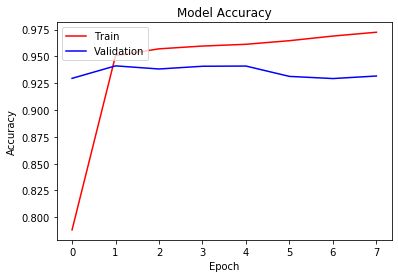

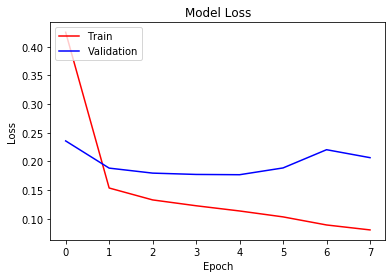

In [106]:
plotLearningCurve(history_m2)

## Model 3:

Convolutional layers improved model 2 performance, however, the model now is overfitting. To minimize this problem, let's add dropout layers:

In [107]:
model_3 = tf.keras.Sequential([

        tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(120,120,3)),

        tf.keras.layers.MaxPool2D(2,2),

        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
        
        tf.keras.layers.MaxPool2D(2,2),
        
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        
        tf.keras.layers.MaxPool2D(2,2),
        
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(units=64, activation = 'relu'),

        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(units=1, activation = 'sigmoid')
        
])


model_3.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [108]:
model_3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_497 (Conv2D)         (None, 118, 118, 16)      448       
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 59, 59, 16)       0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 59, 59, 16)        0         
                                                                 
 conv2d_498 (Conv2D)         (None, 57, 57, 32)        4640      
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 28, 28, 32)      

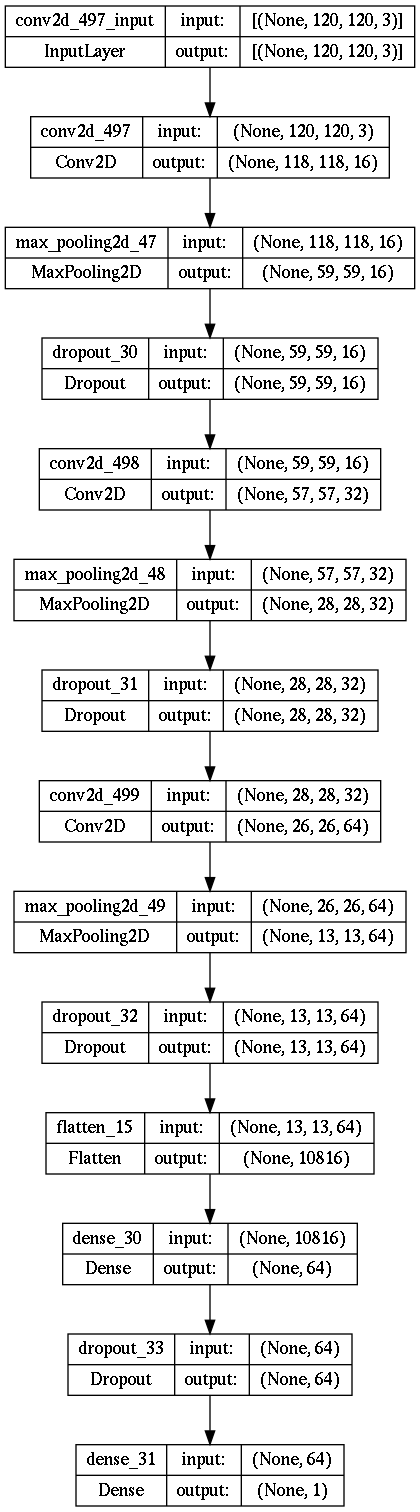

In [109]:
plot_model(model_3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [110]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

history_m3 = model_3.fit_generator(
                                    generator = train_generator,
                                    steps_per_epoch = len(train_generator),
                                    epochs = 20,
                                    validation_data = validation_generator,
                                    validation_steps=len(validation_generator),
                                    callbacks=[early_stop]
                                )

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/20
344/344 [==============================] - 274s 767ms/step - loss: 0.5475 - accuracy: 0.7179 - val_loss: 0.2470 - val_accuracy: 0.9314
Epoch 2/20
344/344 [==============================] - 392s 1s/step - loss: 0.2276 - accuracy: 0.9280 - val_loss: 0.2119 - val_accuracy: 0.9348
Epoch 3/20
344/344 [==============================] - 393s 1s/step - loss: 0.1898 - accuracy: 0.9357 - val_loss: 0.1839 - val_accuracy: 0.9299
Epoch 4/20
344/344 [==============================] - 395s 1s/step - loss: 0.1770 - accuracy: 0.9443 - val_loss: 0.1810 - val_accuracy: 0.9367
Epoch 5/20
344/344 [==============================] - 401s 1s/step - loss: 0.1647 - accuracy: 0.9500 - val_loss: 0.1622 - val_accuracy: 0.9419
Epoch 6/20
344/344 [==============================] - 335s 974ms/step - loss: 0.1562 - accuracy: 0.9533 - val_loss: 0.1654 - val_accuracy: 0.9408
Epoch 7/20
344/344 [==============================] - 455s 1s/step - loss: 0.1488 - accuracy: 0.9551 - val_loss: 0.1850 - val_accuracy: 

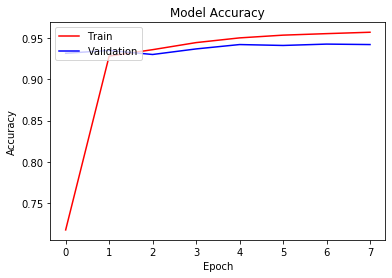

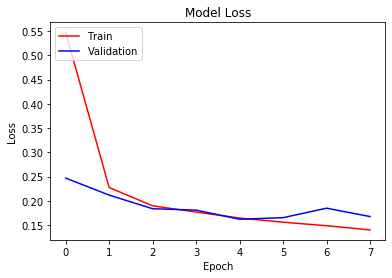

In [111]:
plotLearningCurve(history_m3)

## Model 4:

Dropout layers helped to minimize overfitting. Let's give a try do data augmentation to see if we can improve model 3 performance:

In [222]:
from utils import train_val_generators_data_aug

train_generator2, validation_generator2, test_generator2 = train_val_generators_data_aug(dir)

Found 21976 images belonging to 2 classes.
Found 5494 images belonging to 2 classes.
Found 88 images belonging to 2 classes.


In [162]:
model_4 = tf.keras.Sequential([

        tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(120,120,3)),

        tf.keras.layers.MaxPool2D(2,2),

        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
        
        tf.keras.layers.MaxPool2D(2,2),
        
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        
        tf.keras.layers.MaxPool2D(2,2),
        
        tf.keras.layers.Dropout(0.4),
        
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(units=64, activation = 'relu'),

        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(units=1, activation = 'sigmoid')
        
])


model_4.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [163]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

history_m4 = model_4.fit_generator(
                                    generator = train_generator2,
                                    steps_per_epoch = len(train_generator2),
                                    epochs = 20,
                                    validation_data = validation_generator2,
                                    validation_steps=len(validation_generator2),
                                    callbacks=[early_stop]
                                )

/home/rafaelpavan95/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  if __name__ == '__main__':


Epoch 1/20
344/344 [==============================] - 638s 2s/step - loss: 0.6912 - accuracy: 0.5462 - val_loss: 0.6629 - val_accuracy: 0.6809
Epoch 2/20
344/344 [==============================] - 200s 580ms/step - loss: 0.5597 - accuracy: 0.7450 - val_loss: 0.4367 - val_accuracy: 0.8451
Epoch 3/20
344/344 [==============================] - 188s 546ms/step - loss: 0.3482 - accuracy: 0.8995 - val_loss: 0.3034 - val_accuracy: 0.9039
Epoch 4/20
344/344 [==============================] - 192s 558ms/step - loss: 0.2867 - accuracy: 0.9148 - val_loss: 0.2693 - val_accuracy: 0.9081
Epoch 5/20
344/344 [==============================] - 248s 720ms/step - loss: 0.2590 - accuracy: 0.9186 - val_loss: 0.2417 - val_accuracy: 0.9095
Epoch 6/20
344/344 [==============================] - 384s 1s/step - loss: 0.2501 - accuracy: 0.9207 - val_loss: 0.2288 - val_accuracy: 0.9126
Epoch 7/20
344/344 [==============================] - 475s 1s/step - loss: 0.2457 - accuracy: 0.9208 - val_loss: 0.2349 - val_accu

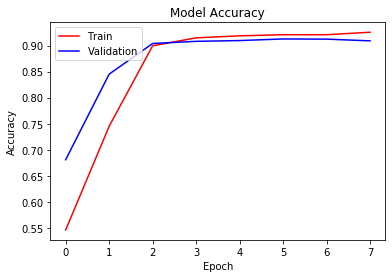

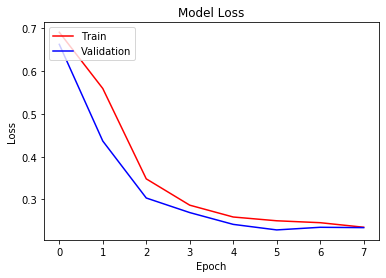

In [164]:
plotLearningCurve(history_m4)

Data augmentation improved model learning curves but final accuracy decreased. In the test_notebook.ipynb let's plot ROC curves and see classification report. 